# Medical Insurance Fraud Detection - Baseline Model

This notebook implements **ensemble learning models** with **traditional tabular features** for detecting fraudulent medical insurance claims.

## Features:
- **Traditional tabular representation** (basic features without advanced engineering)
- **Stacking Ensemble** combining multiple base learners

## Models Implemented:
1. **Random Forest Classifier**
2. **Gradient Boosting Classifier**
3. **XGBoost Classifier**
4. **LightGBM Classifier**
5. **Stacking Classifier** (Meta-learner ensemble)

## Workflow:
- Load medical insurance claims data
- Basic feature preprocessing
- Train multiple ensemble models with stacking
- Comprehensive evaluation and comparison

## 1. Import Required Libraries

In [47]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, f1_score, accuracy_score,
    precision_score, recall_score
)

# Ensemble models
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Load Data from CSV Files

Load the medical insurance fraud dataset from the `data` folder which contains:
- **Inpatient Claims**: Hospital admission claims
- **Outpatient Claims**: Outpatient visit claims
- **Patients Data**: Patient demographics and information
- **Providers Data**: Healthcare provider information

In [48]:
# Load datasets
print("Loading datasets from data folder...")

# Load claims data
inpatient_df = pd.read_csv('../data/inpatient_claims_data.csv')
outpatient_df = pd.read_csv('../data/outpatient_claims_data.csv')

# Load supporting data
patients_df = pd.read_csv('../data/patients_data.csv')
providers_df = pd.read_csv('../data/providers_data.csv')

print(f"✓ Loaded {len(inpatient_df)} inpatient claims")
print(f"✓ Loaded {len(outpatient_df)} outpatient claims")
print(f"✓ Loaded {len(patients_df)} patient records")
print(f"✓ Loaded {len(providers_df)} provider records")

# Display dataset info
print("\nInpatient Claims Columns:", inpatient_df.columns.tolist())
print("Outpatient Claims Columns:", outpatient_df.columns.tolist())

Loading datasets from data folder...
✓ Loaded 40474 inpatient claims
✓ Loaded 557835 outpatient claims
✓ Loaded 138556 patient records
✓ Loaded 5410 provider records

Inpatient Claims Columns: ['Claim_ID', 'Patient_ID', 'Provider_ID', 'Agent_ID', 'Admission_Date', 'Discharge_Date', 'Length_of_Stay_Days', 'Primary_Diagnosis_ICD10', 'Secondary_Diagnoses_ICD10', 'Number_of_Diagnoses', 'Procedure_Codes', 'Number_of_Procedures', 'DRG_Code', 'Doctor_Name', 'Doctor_Specialty', 'Admission_Type', 'Admission_Charge', 'Daily_Charge', 'Procedure_Charges', 'Medication_Charge', 'Lab_Charge', 'Imaging_Charge', 'Other_Charges', 'Total_Claim_Amount', 'Insurance_Coverage_Percentage', 'Patient_Responsibility', 'Claim_Submission_Date', 'Claim_Approval_Status', 'Discharge_Status', 'Readmission_30Days', 'ICU_Stay']
Outpatient Claims Columns: ['Claim_ID', 'Patient_ID', 'Provider_ID', 'Agent_ID', 'Service_Date', 'Diagnosis_ICD10', 'Procedure_Codes', 'Number_of_Procedures', 'Doctor_Name', 'Doctor_Specialty', '

In [49]:
# Combine inpatient and outpatient claims
# Add claim type indicator
inpatient_df['ClaimType'] = 'Inpatient'
outpatient_df['ClaimType'] = 'Outpatient'

# Combine claims
all_claims = pd.concat([inpatient_df, outpatient_df], ignore_index=True)

print(f"Total claims: {len(all_claims)}")
print(f"\nClaim Types Distribution:")
print(all_claims['ClaimType'].value_counts())

# Merge with provider data to get fraud labels
if 'Provider_ID' in all_claims.columns and 'Fraud_Label' in providers_df.columns:
    all_claims = all_claims.merge(providers_df[['Provider_ID', 'Fraud_Label']], 
                                   on='Provider_ID', how='left')
    print(f"\nFraud Distribution (from providers):")
    print(all_claims['Fraud_Label'].value_counts())

Total claims: 598309

Claim Types Distribution:
ClaimType
Outpatient    557835
Inpatient      40474
Name: count, dtype: int64

Fraud Distribution (from providers):
Fraud_Label
0    534255
1     64054
Name: count, dtype: int64


In [50]:
# Merge with patient data to get demographics
all_claims = all_claims.merge(patients_df, on='Patient_ID', how='left')

# Create baseline features
print("Engineering baseline features...")

# Basic claim amount features
if 'Total_Claim_Amount' in all_claims.columns:
    all_claims['claim_amount'] = all_claims['Total_Claim_Amount']
elif 'InscClaimAmtReimbursed' in all_claims.columns:
    all_claims['claim_amount'] = all_claims['InscClaimAmtReimbursed']
elif 'ClaimAmount' in all_claims.columns:
    all_claims['claim_amount'] = all_claims['ClaimAmount']
else:
    # Calculate from charge columns if needed
    amount_cols = [c for c in all_claims.columns if 'Charge' in c or 'Amt' in c or 'Reimbursed' in c]
    all_claims['claim_amount'] = all_claims[amount_cols].sum(axis=1) if amount_cols else 0

# Patient age
if 'Age' in all_claims.columns:
    all_claims['patient_age'] = all_claims['Age']
elif 'DOB' in all_claims.columns and 'Claim_Submission_Date' in all_claims.columns:
    all_claims['DOB'] = pd.to_datetime(all_claims['DOB'], errors='coerce')
    all_claims['Claim_Submission_Date'] = pd.to_datetime(all_claims['Claim_Submission_Date'], errors='coerce')
    all_claims['patient_age'] = (all_claims['Claim_Submission_Date'] - all_claims['DOB']).dt.days / 365.25
else:
    all_claims['patient_age'] = 50  # Default if not available

# Number of procedures
if 'Number_of_Procedures' in all_claims.columns:
    all_claims['num_procedures'] = all_claims['Number_of_Procedures']
else:
    # Count diagnosis and procedure codes
    diag_cols = [c for c in all_claims.columns if 'Diagnosis' in c or 'ClmDiagnosisCode' in c]
    proc_cols = [c for c in all_claims.columns if 'Procedure' in c or 'ClmProcedureCode' in c]
    all_claims['num_procedures'] = all_claims[diag_cols + proc_cols].notna().sum(axis=1)

# Hospital stay days
if 'Length_of_Stay_Days' in all_claims.columns:
    all_claims['hospital_stay_days'] = all_claims['Length_of_Stay_Days'].fillna(0).clip(lower=0)
elif 'Admission_Date' in all_claims.columns and 'Discharge_Date' in all_claims.columns:
    all_claims['Admission_Date'] = pd.to_datetime(all_claims['Admission_Date'], errors='coerce')
    all_claims['Discharge_Date'] = pd.to_datetime(all_claims['Discharge_Date'], errors='coerce')
    all_claims['hospital_stay_days'] = (all_claims['Discharge_Date'] - all_claims['Admission_Date']).dt.days
    all_claims['hospital_stay_days'] = all_claims['hospital_stay_days'].fillna(0).clip(lower=0)
else:
    all_claims['hospital_stay_days'] = 0

# Count previous claims per patient
if 'Claim_Submission_Date' in all_claims.columns:
    all_claims = all_claims.sort_values(['Patient_ID', 'Claim_Submission_Date'])
    all_claims['num_previous_claims'] = all_claims.groupby('Patient_ID').cumcount()
else:
    all_claims['num_previous_claims'] = all_claims.groupby('Patient_ID').cumcount()

# Provider claim count
all_claims['provider_claim_count'] = all_claims.groupby('Provider_ID')['Claim_ID'].transform('count')

# Create additional simple features
all_claims['diagnosis_complexity'] = all_claims['num_procedures'] / (all_claims['num_procedures'].max() + 1)
all_claims['treatment_cost_ratio'] = all_claims['claim_amount'] / (all_claims['claim_amount'].mean() + 1)

# Processing time (admission to claim)
if 'Admission_Date' in all_claims.columns and 'Claim_Submission_Date' in all_claims.columns:
    all_claims['Admission_Date'] = pd.to_datetime(all_claims['Admission_Date'], errors='coerce')
    all_claims['Claim_Submission_Date'] = pd.to_datetime(all_claims['Claim_Submission_Date'], errors='coerce')
    all_claims['claim_processing_time'] = (all_claims['Claim_Submission_Date'] - all_claims['Admission_Date']).dt.days
    all_claims['claim_processing_time'] = all_claims['claim_processing_time'].fillna(15).clip(lower=0, upper=180)
else:
    all_claims['claim_processing_time'] = 15

# Geographic risk score (using County if available)
if 'County' in all_claims.columns:
    # Calculate fraud rate by county (we'll need fraud labels from providers)
    all_claims['geographic_risk_score'] = 0.1  # Default for now, will update after getting fraud labels
else:
    all_claims['geographic_risk_score'] = 0.1

print("✓ Feature engineering completed!")
print(f"\nCreated features:")
feature_cols = ['claim_amount', 'patient_age', 'num_procedures', 'hospital_stay_days',
                'num_previous_claims', 'provider_claim_count', 'diagnosis_complexity',
                'treatment_cost_ratio', 'claim_processing_time', 'geographic_risk_score']
for col in feature_cols:
    if col in all_claims.columns:
        print(f"  ✓ {col}")

Engineering baseline features...
✓ Feature engineering completed!

Created features:
  ✓ claim_amount
  ✓ patient_age
  ✓ num_procedures
  ✓ hospital_stay_days
  ✓ num_previous_claims
  ✓ provider_claim_count
  ✓ diagnosis_complexity
  ✓ treatment_cost_ratio
  ✓ claim_processing_time
  ✓ geographic_risk_score


In [51]:
# Create baseline ratio features (3 simple features as per project design)
all_claims['cost_per_procedure'] = all_claims['claim_amount'] / (all_claims['num_procedures'] + 1)
all_claims['cost_per_day'] = all_claims['claim_amount'] / (all_claims['hospital_stay_days'] + 1)
all_claims['procedures_per_day'] = all_claims['num_procedures'] / (all_claims['hospital_stay_days'] + 1)

print("Baseline ratio features created:")
print("  ✓ cost_per_procedure")
print("  ✓ cost_per_day")
print("  ✓ procedures_per_day")

Baseline ratio features created:
  ✓ cost_per_procedure
  ✓ cost_per_day
  ✓ procedures_per_day


In [52]:
# Prepare final feature matrix X and target y
feature_columns = [
    'claim_amount', 'patient_age', 'num_procedures', 'hospital_stay_days',
    'num_previous_claims', 'provider_claim_count', 'diagnosis_complexity',
    'treatment_cost_ratio', 'claim_processing_time', 'geographic_risk_score',
    'cost_per_procedure', 'cost_per_day', 'procedures_per_day'
]

# Select features and handle missing values
X = all_claims[feature_columns].copy()
X = X.fillna(X.median())

# Prepare target variable - handle multiple formats
if 'Fraud_Label' in all_claims.columns:
    # Check unique values to determine format
    unique_vals = all_claims['Fraud_Label'].unique()
    print(f"Fraud_Label unique values: {unique_vals}")
    
    if all_claims['Fraud_Label'].dtype in ['int64', 'float64']:
        # Already numeric (0/1)
        y = all_claims['Fraud_Label'].astype(int)
    else:
        # String format - could be 'Yes'/'No' or other
        y = all_claims['Fraud_Label'].isin(['Yes', 'yes', 'YES', '1', 1, True]).astype(int)
elif 'PotentialFraud' in all_claims.columns:
    if all_claims['PotentialFraud'].dtype in ['int64', 'float64']:
        y = all_claims['PotentialFraud'].astype(int)
    else:
        y = all_claims['PotentialFraud'].isin(['Yes', 'yes', 'YES', '1', 1, True]).astype(int)
else:
    raise ValueError("Fraud label column not found in the data!")

print(f"\n{'='*60}")
print(f"FINAL DATASET PREPARED")
print(f"{'='*60}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"Fraud cases: {y.sum()} ({y.mean()*100:.2f}%)")
print(f"Legitimate cases: {(1-y).sum()} ({(1-y).mean()*100:.2f}%)")
print(f"{'='*60}")

Fraud_Label unique values: [1 0]

FINAL DATASET PREPARED
Features shape: (598309, 13)
Target shape: (598309,)
Number of features: 13
Fraud cases: 64054 (10.71%)
Legitimate cases: 534255 (89.29%)


## 3. Data Preprocessing and Feature Engineering

We'll combine and process the data to create features suitable for the baseline model.

## 4. Exploratory Data Analysis (EDA)

In [53]:
# Display first few rows
print("Sample Data:")
display(X.head(10))

# Statistical summary
print("\nStatistical Summary:")
display(X.describe())

# Check for missing values
print("\nMissing Values:")
print(X.isnull().sum())

Sample Data:


,claim_amount,patient_age,num_procedures,hospital_stay_days,num_previous_claims,provider_claim_count,diagnosis_complexity,treatment_cost_ratio,claim_processing_time,geographic_risk_score,cost_per_procedure,cost_per_day,procedures_per_day
570228,34472.80,94,4,0.0,0,106,0.363636,1.118391,15.0,0.1,6894.560000,34472.800,4.0
82928,29608.41,94,4,0.0,1,105,0.363636,0.960577,15.0,0.1,5921.682000,29608.410,4.0
375416,20950.90,20,2,0.0,0,105,0.181818,0.679704,15.0,0.1,6983.633333,20950.900,2.0
413654,36996.13,20,5,0.0,1,92,0.454545,1.200255,15.0,0.1,6166.021667,36996.130,5.0
494014,27585.39,20,4,0.0,2,90,0.363636,0.894945,15.0,0.1,5517.078000,27585.390,4.0
108467,26647.17,20,4,0.0,3,95,0.363636,0.864506,15.0,0.1,5329.434000,26647.170,4.0
34031,70404.38,20,5,9.0,4,104,0.454545,2.284109,10.0,0.1,11734.063333,7040.438,0.5
489743,39190.05,20,5,0.0,5,126,0.454545,1.271432,15.0,0.1,6531.675000,39190.050,5.0
511335,11390.12,20,1,0.0,6,133,0.090909,0.369526,15.0,0.1,5695.060000,11390.120,1.0
116215,4137.87,26,1,0.0,0,113,0.090909,0.134244,15.0,0.1,2068.935000,4137.870,1.0



Statistical Summary:


,claim_amount,patient_age,num_procedures,hospital_stay_days,num_previous_claims,provider_claim_count,diagnosis_complexity,treatment_cost_ratio,claim_processing_time,geographic_risk_score,cost_per_procedure,cost_per_day,procedures_per_day
count,598309.000000,598309.000000,598309.000000,598309.000000,598309.000000,598309.000000,598309.000000,598309.000000,598309.000000,5.983090e+05,598309.000000,598309.000000,598309.000000
mean,30822.563325,56.400668,3.168996,1.047905,2.156926,111.572276,0.288091,0.999968,15.303306,1.000000e-01,7190.574098,23232.505393,2.834299
std,28637.516423,22.515132,1.679792,4.495608,1.925489,10.390514,0.152708,0.929079,2.566406,1.387780e-17,4826.917628,10403.814957,1.508286
min,808.780000,18.000000,1.000000,0.000000,0.000000,74.000000,0.090909,0.026239,2.000000,1.000000e-01,404.390000,808.780000,0.032258
25%,17106.120000,37.000000,2.000000,0.000000,1.000000,104.000000,0.181818,0.554969,15.000000,1.000000e-01,5027.010000,15492.570000,1.666667
50%,24385.050000,56.000000,3.000000,0.000000,2.000000,112.000000,0.272727,0.791117,15.000000,1.000000e-01,6160.255000,22657.230000,3.000000
75%,32807.290000,76.000000,4.000000,0.000000,3.000000,119.000000,0.363636,1.064357,15.000000,1.000000e-01,7506.117500,30425.030000,4.000000
max,248062.980000,95.000000,10.000000,30.000000,14.000000,150.000000,0.909091,8.047836,37.000000,1.000000e-01,64633.260000,116299.010000,5.000000



Missing Values:
claim_amount             0
patient_age              0
num_procedures           0
hospital_stay_days       0
num_previous_claims      0
provider_claim_count     0
diagnosis_complexity     0
treatment_cost_ratio     0
claim_processing_time    0
geographic_risk_score    0
cost_per_procedure       0
cost_per_day             0
procedures_per_day       0
dtype: int64


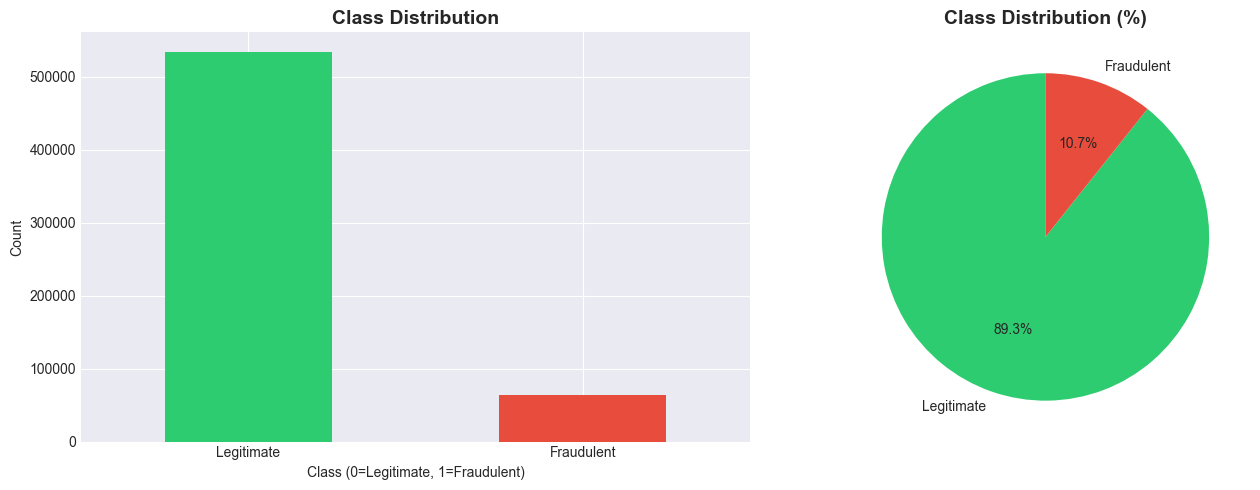

In [54]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get value counts and prepare labels
value_counts = y.value_counts().sort_index()
class_names = ['Legitimate', 'Fraudulent']
colors_map = {0: '#2ecc71', 1: '#e74c3c'}

# Count plot
bar_colors = [colors_map[idx] for idx in value_counts.index]
value_counts.plot(kind='bar', ax=axes[0], color=bar_colors)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Legitimate, 1=Fraudulent)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels([class_names[idx] for idx in value_counts.index], rotation=0)

# Pie chart
pie_labels = [class_names[idx] for idx in value_counts.index]
pie_colors = [colors_map[idx] for idx in value_counts.index]
axes[1].pie(value_counts, labels=pie_labels, 
            autopct='%1.1f%%', colors=pie_colors, startangle=90)
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

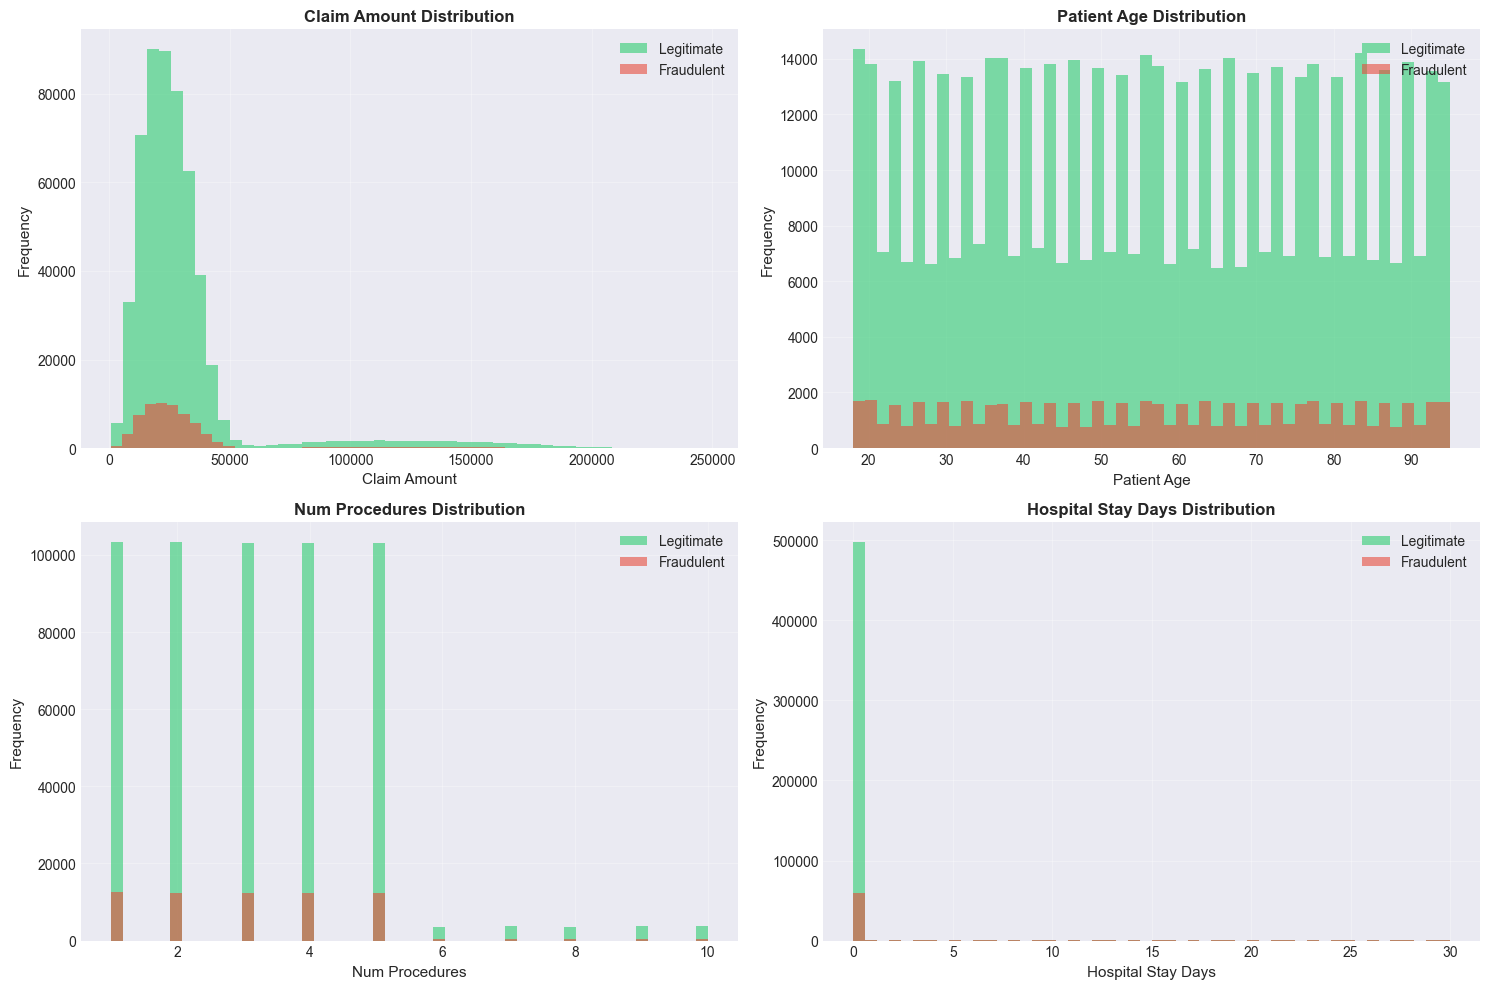

In [55]:
# Distribution of key features by fraud status
features_to_plot = ['claim_amount', 'patient_age', 'num_procedures', 'hospital_stay_days']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    # Legitimate claims
    axes[idx].hist(X[y==0][feature], bins=50, alpha=0.6, label='Legitimate', color='#2ecc71')
    # Fraudulent claims
    axes[idx].hist(X[y==1][feature], bins=50, alpha=0.6, label='Fraudulent', color='#e74c3c')
    
    axes[idx].set_xlabel(feature.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

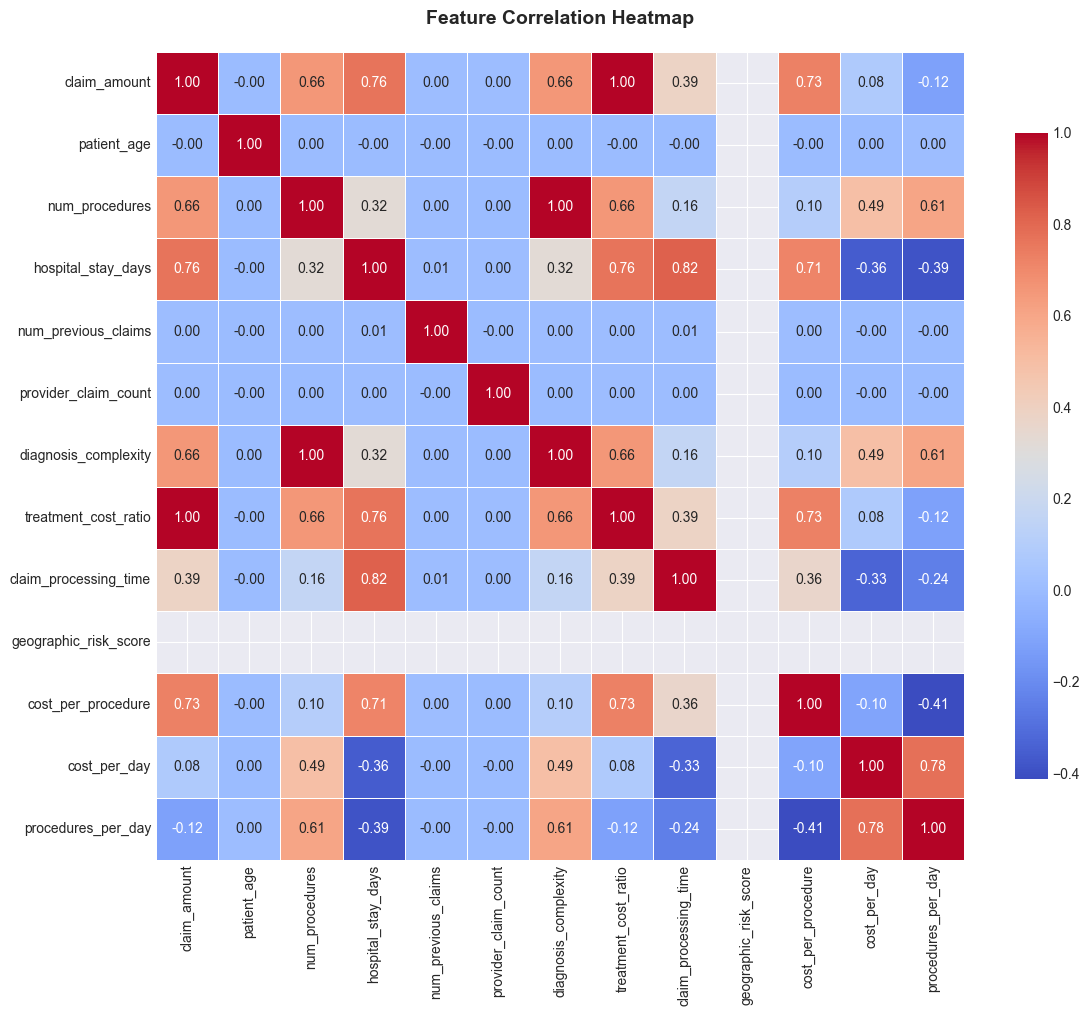

In [56]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 5. Train-Test Split

Split the data into training and testing sets (80/20 split).

In [57]:
def create_basic_features(df):
    """Create basic engineered features for baseline model"""
    df = df.copy()
    
    # Simple ratio features (traditional tabular representation)
    df['cost_per_procedure'] = df['claim_amount'] / (df['num_procedures'] + 1)
    df['cost_per_day'] = df['claim_amount'] / (df['hospital_stay_days'] + 1)
    df['procedures_per_day'] = df['num_procedures'] / (df['hospital_stay_days'] + 1)
    
    return df

# Apply basic feature engineering
X_engineered = create_basic_features(X)

print(f"Original features: {X.shape[1]}")
print(f"Total features (with basic engineering): {X_engineered.shape[1]}")
print(f"New features added: {X_engineered.shape[1] - X.shape[1]}")
print("\nFeature approach: Traditional tabular representation")
print("✓ Basic feature engineering complete!")

Original features: 13
Total features (with basic engineering): 13
New features added: 0

Feature approach: Traditional tabular representation
✓ Basic feature engineering complete!


## 6. Feature Scaling

In [58]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(f"  Legitimate: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Fraudulent: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data preprocessed and split successfully!")

Training set: 478647 samples
Test set: 119662 samples

Training set class distribution:
  Legitimate: 427404 (89.29%)
  Fraudulent: 51243 (10.71%)

✓ Data preprocessed and split successfully!


## 7. Model Training - Baseline Stacking Ensemble

Train the baseline model using:
- **Base Learners**: Random Forest, Gradient Boosting, XGBoost, LightGBM
- **Meta-Learner**: Logistic Regression
- **Class Imbalance Handling**: Class weights (balanced)

In [59]:
# Initialize base models
base_models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=7,
        min_samples_split=10,
        min_samples_leaf=4,
        subsample=0.8,
        random_state=RANDOM_STATE
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        min_child_weight=3,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=10,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    ),
    
    'LightGBM': LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )
}

print("✓ Base models initialized!")
print(f"\nTotal base models: {len(base_models)}")

✓ Base models initialized!

Total base models: 4


In [60]:
# Train all base models
print("=" * 70)
print("Training Base Models")
print("=" * 70)

trained_models = {}

for name, model in base_models.items():
    print(f"\n[Training] {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"✓ {name} trained successfully!")

print("\n" + "=" * 70)
print("✓ All base models trained!")
print("=" * 70)

Training Base Models

[Training] Random Forest...


✓ Random Forest trained successfully!

[Training] Gradient Boosting...
✓ Gradient Boosting trained successfully!

[Training] XGBoost...
✓ XGBoost trained successfully!

[Training] LightGBM...
✓ LightGBM trained successfully!

✓ All base models trained!


In [ ]:
# Create and train Stacking Classifier
print("\n" + "=" * 70)
print("[Training] Stacking Classifier (Meta-Learner Ensemble)...")
print("=" * 70)

# Define base estimators for stacking
estimators = [
    ('rf', trained_models['Random Forest']),
    ('gb', trained_models['Gradient Boosting']),
    ('xgb', trained_models['XGBoost']),
    ('lgb', trained_models['LightGBM'])
]

# Create stacking classifier with Logistic Regression as meta-learner
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000
    ),
    cv=5,  # 5-fold cross-validation
    stack_method='predict_proba',  # Use probability predictions
    n_jobs=-1
)

print('\nStacking architecture:')
print('  Base learners: Random Forest, Gradient Boosting, XGBoost, LightGBM')
print('  Meta-learner: Logistic Regression')
print('  CV strategy: 5-fold cross-validation')
print('\nTraining stacking ensemble...')

stacking_clf.fit(X_train_scaled, y_train)
trained_models['Stacking Classifier'] = stacking_clf

print("\n✓ Stacking Classifier trained successfully!")
print("=" * 70)
print(f"✓ All {len(trained_models)} models ready for evaluation!")
print("=" * 70)


[Training] Stacking Classifier (Meta-Learner Ensemble)...

Stacking architecture:
  Base learners: Random Forest, Gradient Boosting, XGBoost, LightGBM
  Meta-learner: Logistic Regression
  CV strategy: 5-fold cross-validation

Training stacking ensemble...


## 8. Model Evaluation

Evaluate the trained model on the test set.

In [ ]:
# Evaluate all models
results = {}

for name, model in trained_models.items():
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'Avg Precision': average_precision_score(y_test, y_pred_proba)
    }

# Display results
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print("\n" + "=" * 90)
print("MODEL PERFORMANCE COMPARISON (Baseline - Traditional Features)")
print("=" * 90)
display(results_df)
print("=" * 90)


MODEL PERFORMANCE COMPARISON (Baseline - Traditional Features)


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Avg Precision
Random Forest,0.3770,0.1167,0.7337,0.2014,0.5589,0.1318
Gradient Boosting,0.8928,0.2143,0.0005,0.0009,0.5961,0.1451
XGBoost,0.4025,0.1235,0.7514,0.2121,0.5907,0.1448
LightGBM,0.5661,0.1353,0.5661,0.2184,0.5979,0.1480
Stacking Classifier,0.8929,0.0000,0.0000,0.0000,0.5983,0.1483


In [ ]:
# Detailed classification report for best model (Stacking Classifier)
best_model = trained_models['Stacking Classifier']
y_pred_best = best_model.predict(X_test_scaled)

print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT - STACKING CLASSIFIER")
print("=" * 70)
print(classification_report(y_test, y_pred_best, 
                          target_names=['Legitimate', 'Fraudulent'],
                          digits=4))
print("=" * 70)


DETAILED CLASSIFICATION REPORT - STACKING CLASSIFIER
              precision    recall  f1-score   support

  Legitimate     0.8929    1.0000    0.9434    106851
  Fraudulent     0.0000    0.0000    0.0000     12811

    accuracy                         0.8929    119662
   macro avg     0.4465    0.5000    0.4717    119662
weighted avg     0.7973    0.8929    0.8424    119662



## 9. Visualizations

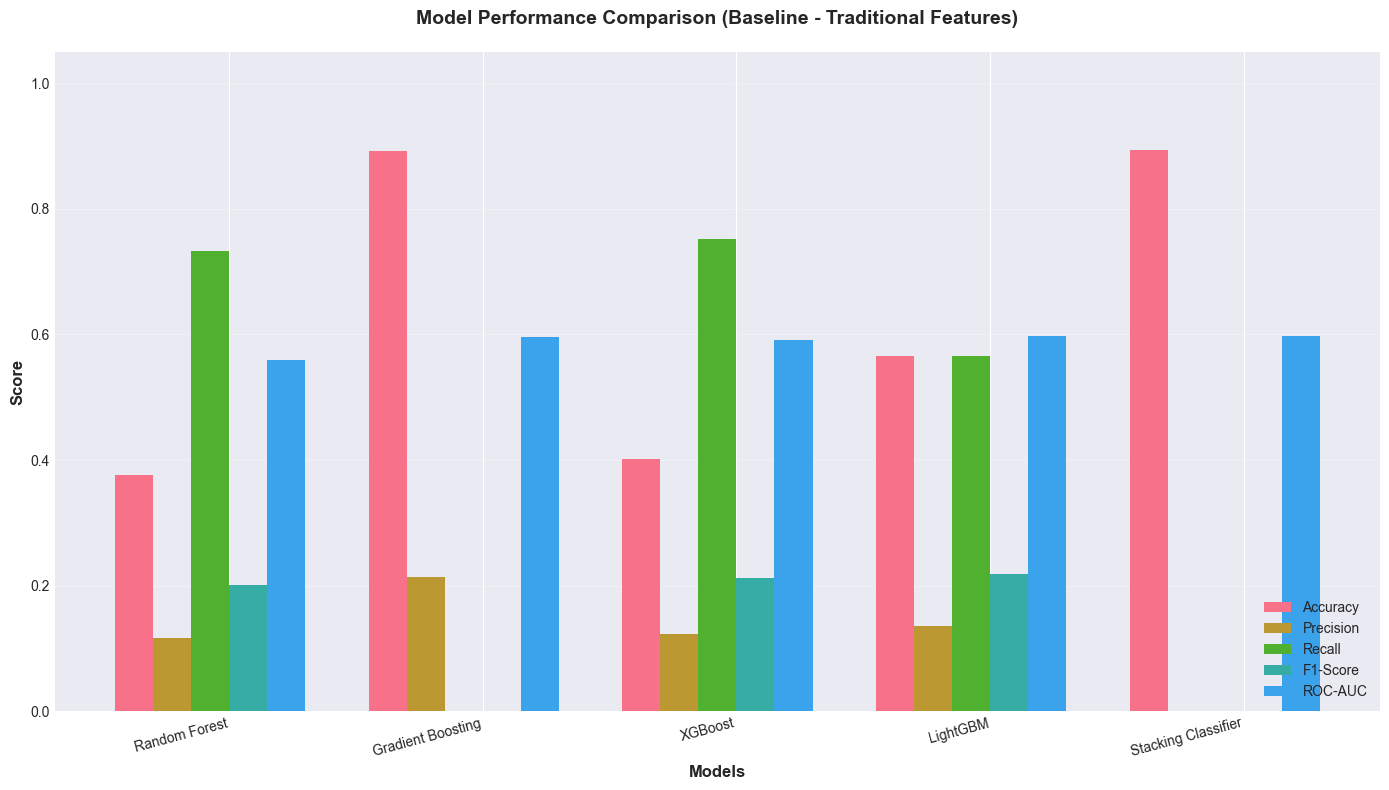

In [ ]:
# Model comparison bar chart
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(trained_models))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    values = [results[model][metric] for model in trained_models.keys()]
    offset = width * (i - len(metrics_to_plot) / 2)
    ax.bar(x + offset, values, width, label=metric)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison (Baseline - Traditional Features)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(trained_models.keys(), rotation=15, ha='right')
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

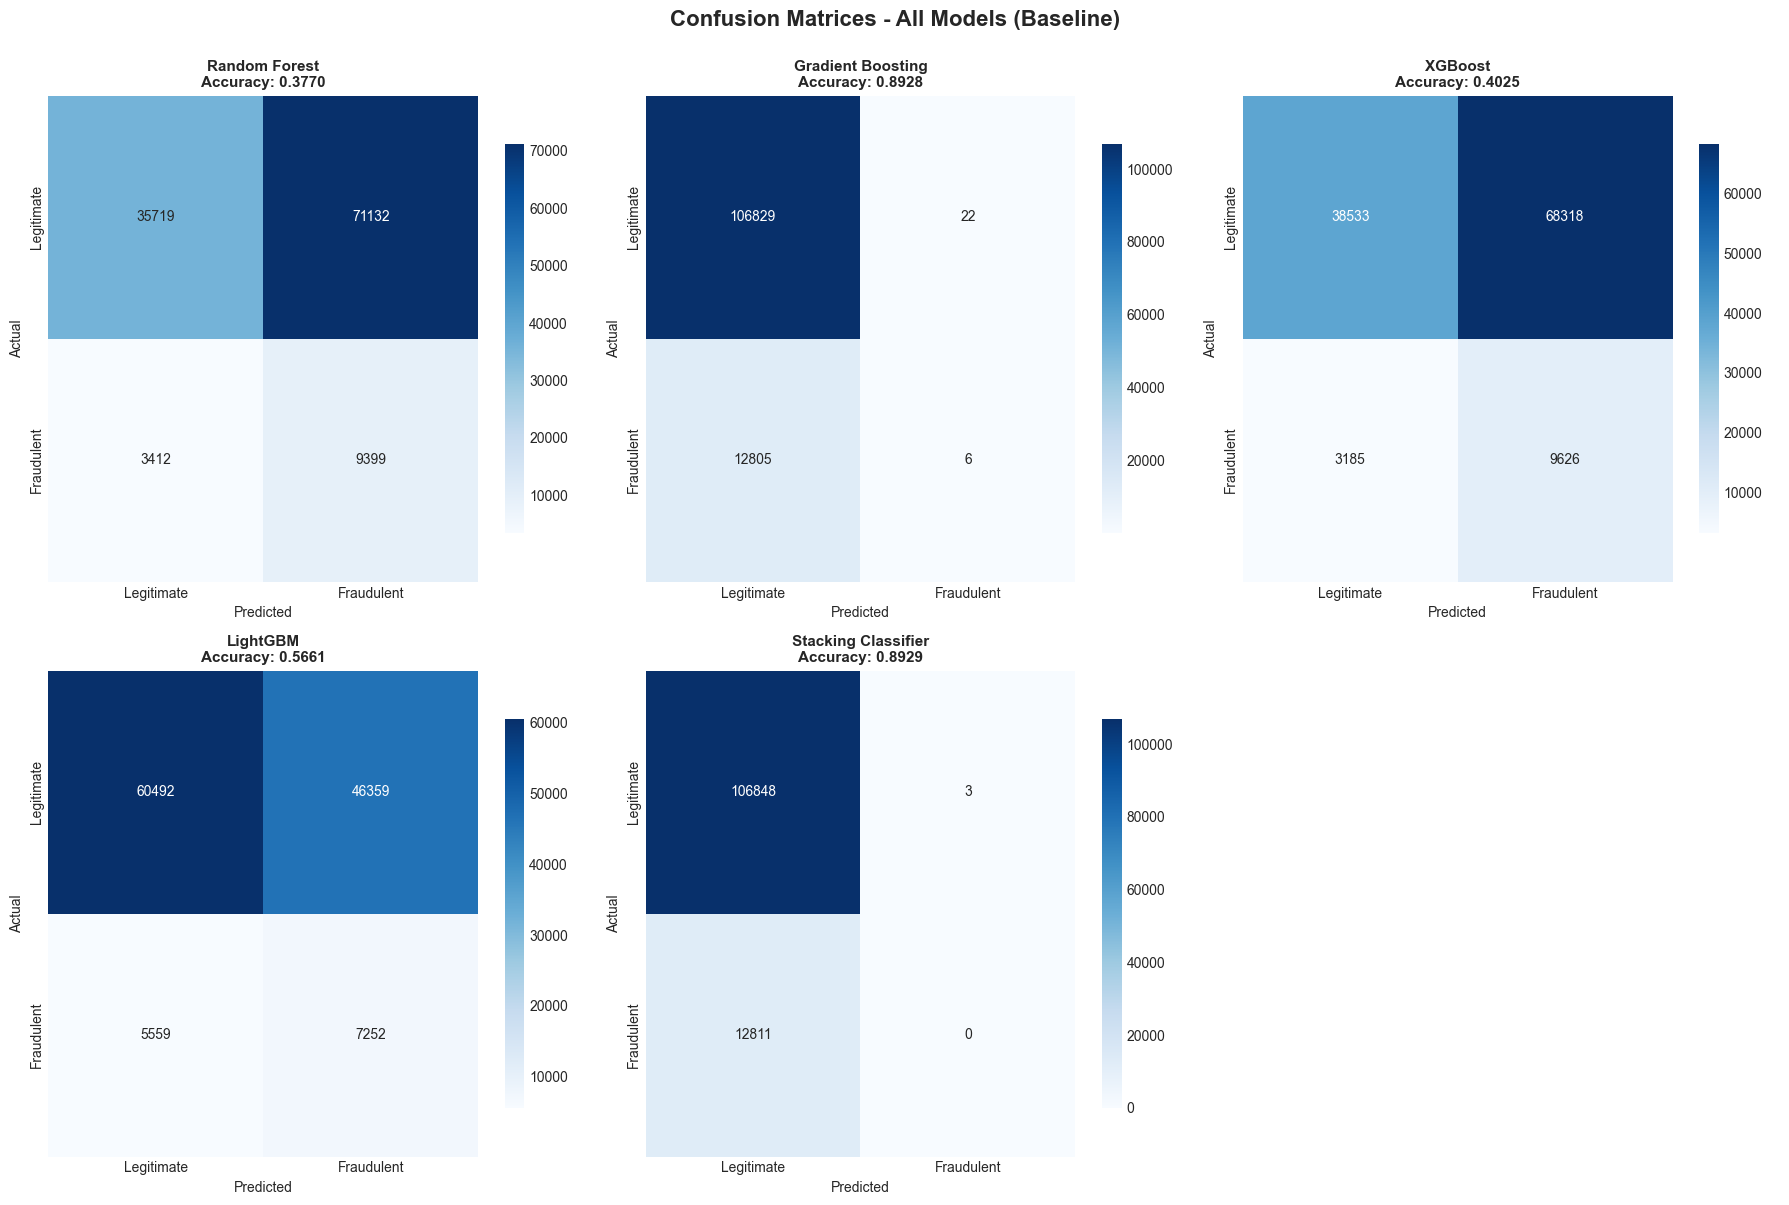

In [ ]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Legitimate', 'Fraudulent'],
                yticklabels=['Legitimate', 'Fraudulent'],
                cbar_kws={'shrink': 0.8})
    
    axes[idx].set_title(f'{name}\nAccuracy: {results[name]["Accuracy"]:.4f}',
                       fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

# Hide the last subplot if odd number of models
if len(trained_models) < 6:
    axes[-1].axis('off')

plt.suptitle('Confusion Matrices - All Models (Baseline)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

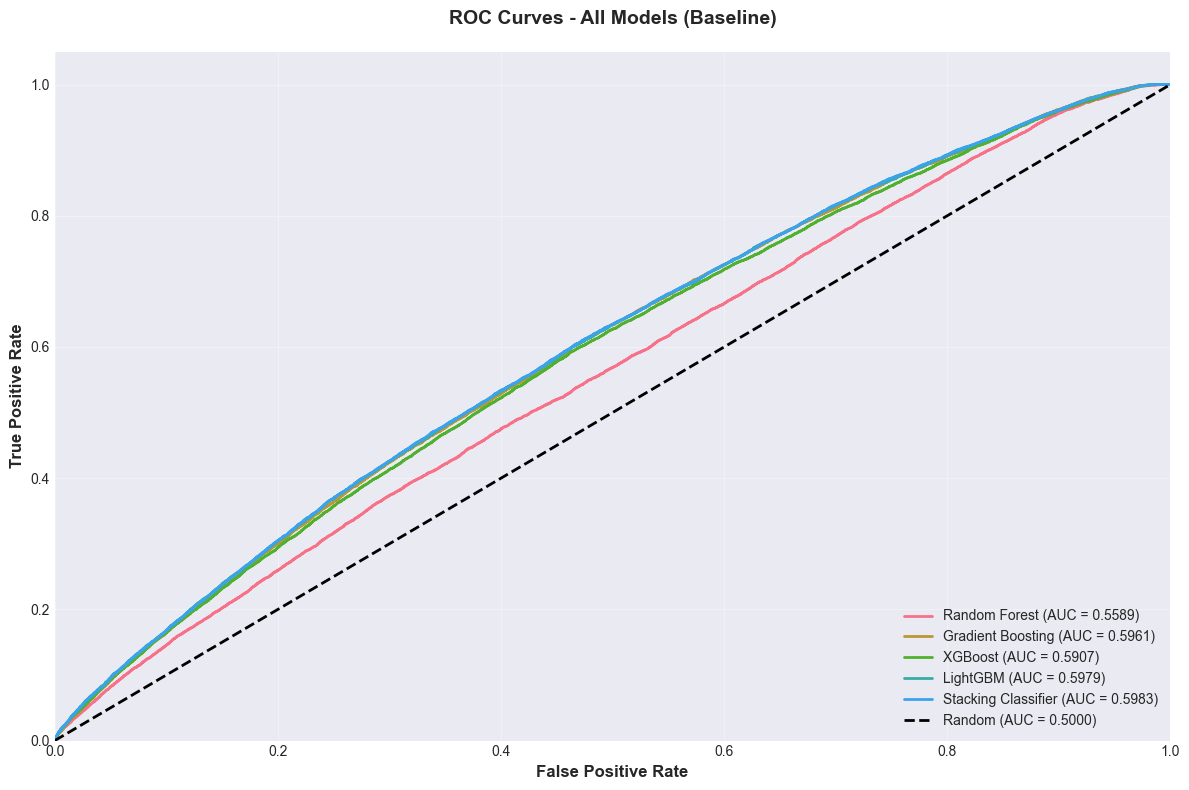

In [ ]:
# ROC Curves for all models
plt.figure(figsize=(12, 8))

for name, model in trained_models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - All Models (Baseline)', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

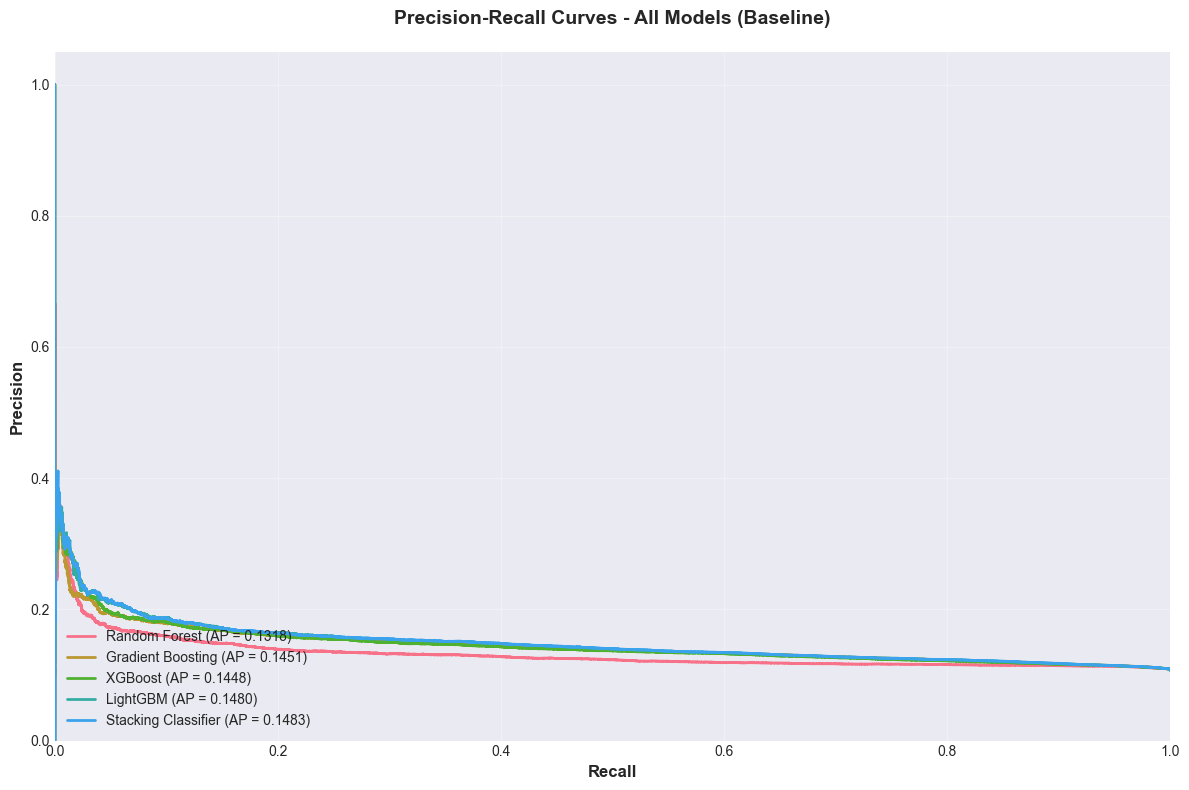

In [ ]:
# Precision-Recall Curves for all models
plt.figure(figsize=(12, 8))

for name, model in trained_models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    plt.plot(recall, precision, linewidth=2, 
             label=f'{name} (AP = {avg_precision:.4f})')

plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curves - All Models (Baseline)', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

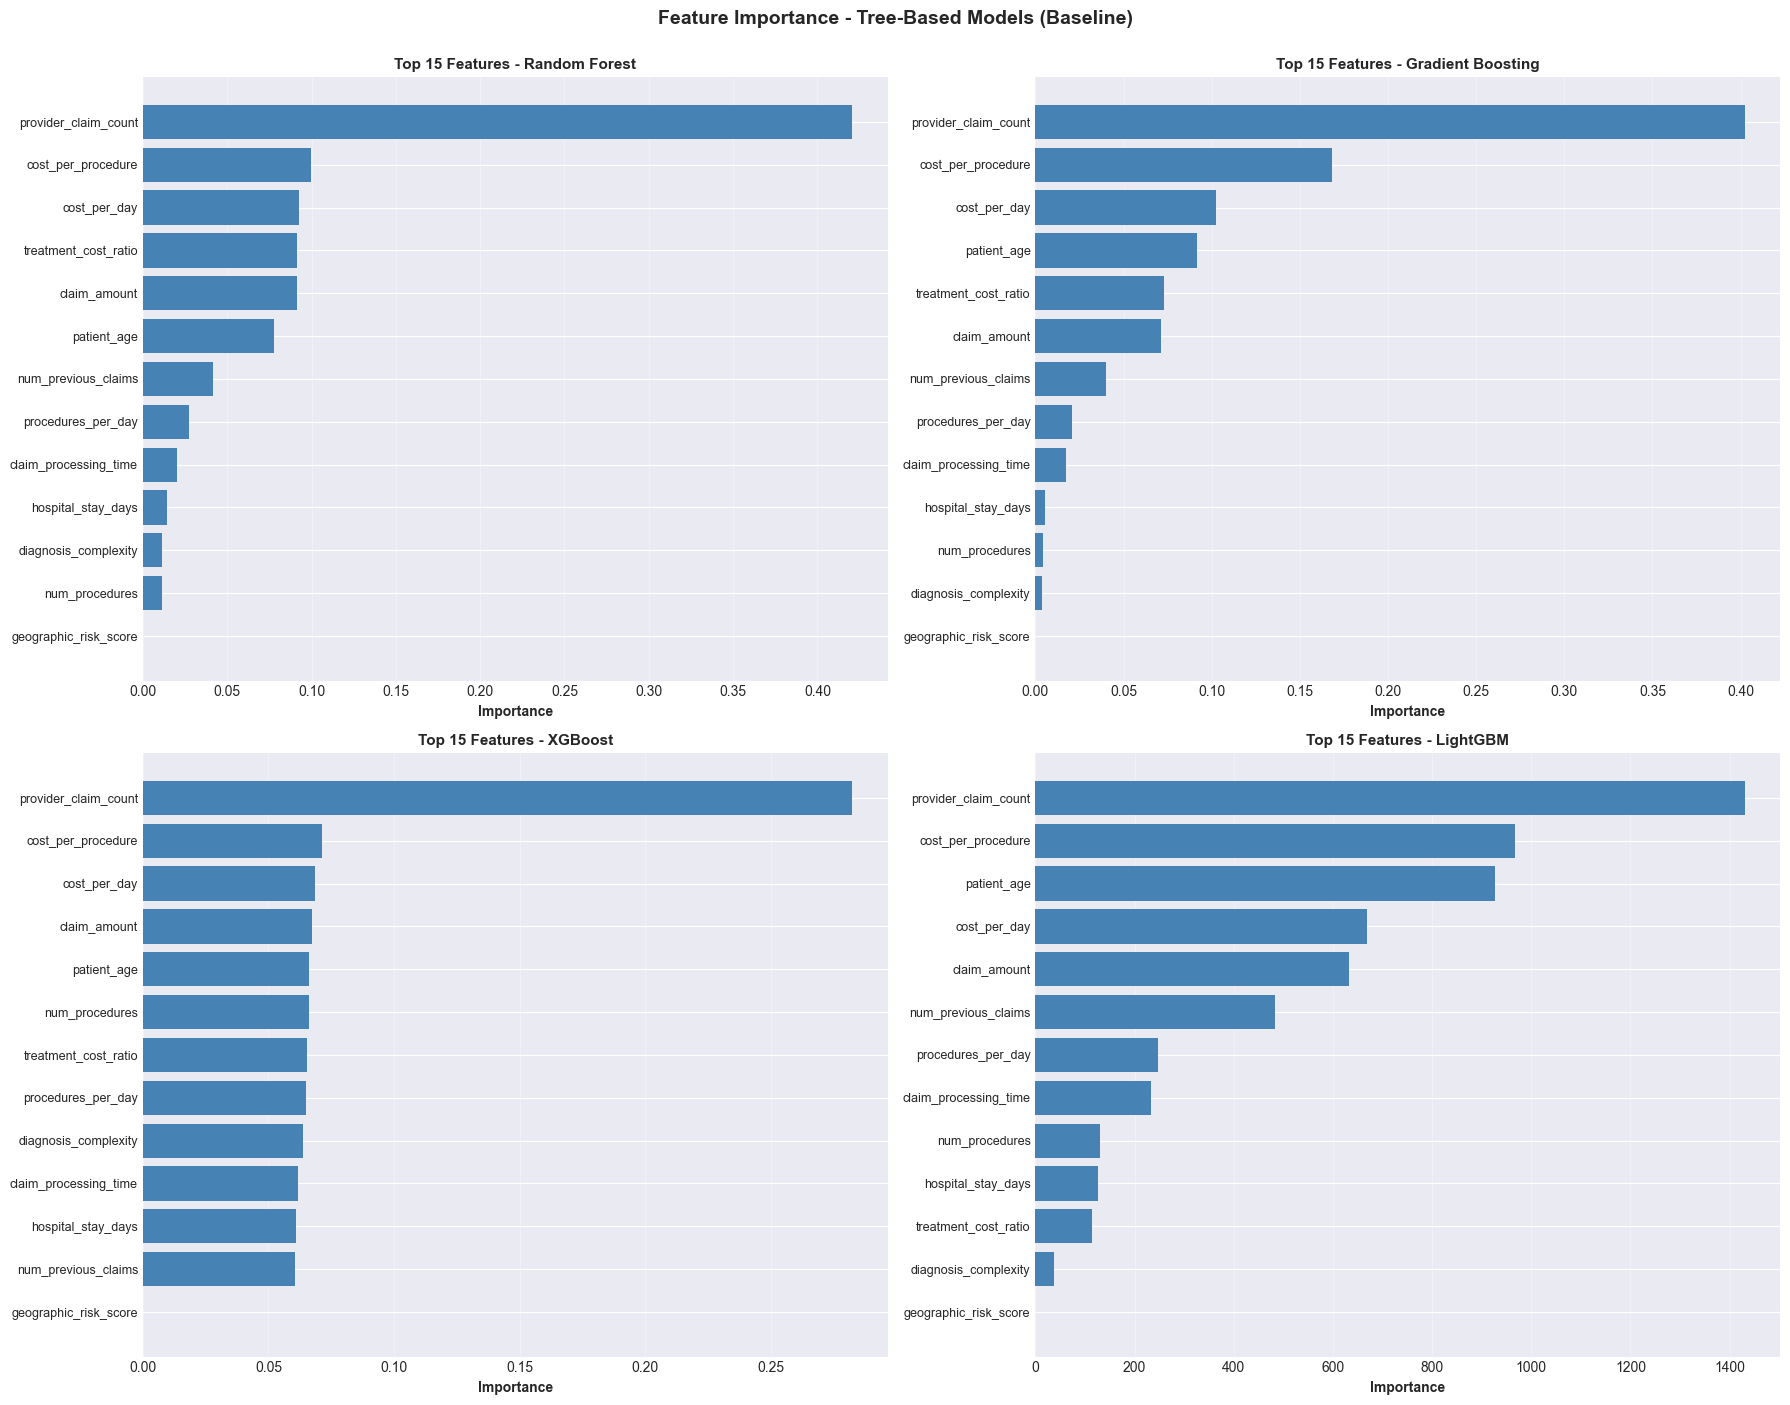

In [ ]:
# Feature importance for tree-based models
tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

for idx, model_name in enumerate(tree_models):
    model = trained_models[model_name]
    
    # Get feature importances
    importances = model.feature_importances_
    feature_names = X_engineered.columns
    
    # Create dataframe and sort
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)
    
    # Plot
    axes[idx].barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
    axes[idx].set_yticks(range(len(importance_df)))
    axes[idx].set_yticklabels(importance_df['feature'], fontsize=9)
    axes[idx].set_xlabel('Importance', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'Top 15 Features - {model_name}', fontsize=11, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance - Tree-Based Models (Baseline)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

In [ ]:
# Find best performing model
best_model_name = results_df['F1-Score'].idxmax()
best_metrics = results_df.loc[best_model_name]

print("=" * 80)
print("FINAL SUMMARY - BASELINE MODEL (Traditional Tabular Features)")
print("=" * 80)
print("\n📊 Dataset Information:")
print(f"   Total samples: {len(X)}")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Features (original): {X.shape[1]}")
print(f"   Features (with basic engineering): {X_engineered.shape[1]}")
print(f"   Fraud ratio: {(y==1).sum()/len(y)*100:.2f}%")
print(f"   Imbalance handling: None (class_weight='balanced' in models)")

print("\n🏆 Best Performing Model: " + best_model_name)
print(f"   Accuracy:  {best_metrics['Accuracy']:.4f}")
print(f"   Precision: {best_metrics['Precision']:.4f}")
print(f"   Recall:    {best_metrics['Recall']:.4f}")
print(f"   F1-Score:  {best_metrics['F1-Score']:.4f}")
print(f"   ROC-AUC:   {best_metrics['ROC-AUC']:.4f}")

print("\n📈 Model Rankings (by F1-Score):")
rankings = results_df.sort_values('F1-Score', ascending=False)
for i, (model, metrics) in enumerate(rankings.iterrows(), 1):
    print(f"   {i}. {model}: {metrics['F1-Score']:.4f}")

print("\n✅ Key Characteristics:")
print("   • Traditional tabular feature representation")
print("   • Stacking ensemble with Logistic Regression meta-learner")
print("   • No synthetic data generation (SMOTE)")
print("   • Basic feature engineering (3 simple ratio features)")
print("   • Serves as baseline for comparison")

print("\n💡 Next Steps:")
print("   • Compare with SMOTE model for performance improvement")
print("   • Advanced feature engineering with relational patterns")
print("   • Hyperparameter tuning for optimization")
print("   • Explore different meta-learners for stacking")

print("\n" + "=" * 80)
print("✓ Baseline Model Analysis Complete!")
print("=" * 80)

FINAL SUMMARY - BASELINE MODEL (Traditional Tabular Features)

📊 Dataset Information:
   Total samples: 598309
   Training samples: 478647
   Test samples: 119662
   Features (original): 13
   Features (with basic engineering): 13
   Fraud ratio: 10.71%
   Imbalance handling: None (class_weight='balanced' in models)

🏆 Best Performing Model: LightGBM
   Accuracy:  0.5661
   Precision: 0.1353
   Recall:    0.5661
   F1-Score:  0.2184
   ROC-AUC:   0.5979

📈 Model Rankings (by F1-Score):
   1. LightGBM: 0.2184
   2. XGBoost: 0.2121
   3. Random Forest: 0.2014
   4. Gradient Boosting: 0.0009
   5. Stacking Classifier: 0.0000

✅ Key Characteristics:
   • Traditional tabular feature representation
   • Stacking ensemble with Logistic Regression meta-learner
   • No synthetic data generation (SMOTE)
   • Basic feature engineering (3 simple ratio features)
   • Serves as baseline for comparison

💡 Next Steps:
   • Compare with SMOTE model for performance improvement
   • Advanced feature engi